# waves - SXR
For calculating several LOSs from SAV files

In [476]:
#import math
from scipy import io
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import scipy.integrate
import pandas as pd
from IPython.display import display
import time
import matplotlib.colors as colors
import random
import pandas as pd
from matplotlib import animation
from IPython.display import HTML
import glob
import os

**main variables**
<br> f - main frequency (Hz)
<br> full_f - the entire time-frequency function (Hz) ("x" as x axis)
<br> frangemax - x axis length of Fourier-transform, note, that this does not affect Fourier calculation
<br> samples - sample points of the first graph
<br> s_rate - sample rate (Hz)
<br> amp - amplitude of signal
<br> randamp - amplitude of noise (random noise)
<br> <br> First, we create our signal and noise. In deafult: a sine wave, and a white noise.
<br> Or import one in.

In [477]:
#%%script false
path ='E:\\marci main\\Fusion\\inputdata\\in'#pc
#path ='C:\\Users\\win10\\Downloads\\transient-waves\\inputdata\\in\\'#laptop

for filename in glob.glob(os.path.join(path, '*.sav')):
    sav1 = io.readsav(filename, python_dict = True)
    print('Loaded: '+filename)
    print('\n')

Loaded: E:\marci main\Fusion\inputdata\in\AUGD_32326_MHA.sav




In [478]:
#%%script false

frangemax=200000#nyquist
shot_i=1
#print(sav1)
s=np.array(sav1['data'][shot_i])#
x=np.array(sav1['timeax'])
t = max(x) - min(x)
#print("\n", sav1['channels'])
print("\n", s)
#print("\n", sav1['channels'][shot_i])
sxr_name=str(sav1['channels'][shot_i])[2:4]+'R'+str(sav1['channels'][shot_i])[5:-1]
shot=os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10]+', '+sxr_name#str(sav1['channels'][shot_i])[2:-1]
save_shot = os.path.basename(filename)[:4]+'_'+os.path.basename(filename)[5:10]
print("\n",shot)

#C:\\Users\\win10\\Downloads\\transient-waves\\inputdata\\AUGD_34924_2208_2238_Loaded-with-MTR.sav - nullközepű 
#AUGD_34924_J051_240_245_Loaded-with-MTR.sav - nem nullközepű SXR
#AUGD_28881_Loaded-with-MTR.sav - toroidális mágneses tekercs AUGD_28881_Loaded-with-MTR.sav
#C:\\Users\\Marci\\Documents\\transientwaves\\imputdata\\AUGD_34924_2208_2238_Loaded-with-MTR.sav


 [-0.90766746 -0.8974117  -0.7743345  ...  0.43591818  0.57950693
  0.50771654]

 AUGD 32326, MHR-B31-03


In [479]:
#%%script false
min_t=min(x)#0#1.9
max_t=max(x)#t#2.2

amp_name = "Amplitúdó (W/m^2)" #(T/s)

s = s.astype(float)
x = x.astype(float)
samples=s.size
#full_f = np.zeros(samples)
t=max(x)-min(x)
nyquist=samples/2/t
#frangemax=nyquist#250000#
xf=np.linspace(0.0, frangemax, frangemax*t+1)
s_rate=x.size/t

t=max_t-min_t
min_x=int(s_rate*(min_t-min(x)))
max_x=int(s_rate*(max_t-min(x)))
samples=max_x-min_x

x=x[min_x:max_x]
s=s[min_x:max_x]

print(max_t)
print(frangemax)
print(x.size)

0.95
200000
200001


C:\Users\Marci\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


In [481]:
#%%script false
#path ='C:\\Users\\Marci\\Documents\\transientwaves\\imputdata\\in\\'#pc
path ='E:\\marci main\\Fusion\\inputdata\\in\\' #pc_big 
#path ='C:\\Users\\win10\\Downloads\\transient-waves\\inputdata\\in\\'#laptop

loops = np.size(sav1['channels'])#17#
zero_loops = 0

for shot_i in range(loops): 
    win_r = 5000 #1000
    d_win=300#random.randint(200,300)
    std=500 #150
    
    s=np.array(sav1['data'][shot_i])#
    if (np.average(abs(s))) < 0.1:
        #shot_i=shot_i+1
        zero_loops = zero_loops+1
        print('zeros shot:',shot_i)
        #s=np.array(sav1['data'][shot_i])
    x=np.array(sav1['timeax'])
    s = s.astype(float)
    x = x.astype(float)
    samples=s.size
    t = max(x) - min(x)
    stft_len = int(samples/d_win+0.9)
    
    sxr_name=str(sav1['channels'][shot_i])[2:4]+'R'+str(sav1['channels'][shot_i])[5:-1]
    if shot_i == 0:
        shot_name=[(str(os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10]+', '+sxr_name))]
        
    else:
        shot_name.append(str(os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10]+', '+sxr_name))
    print("\n","shot: ",shot_i, "  name: ",shot_name[shot_i])
    print("\n")

    print('Calculating main variables...')
    min_t=min(x)#0.85#,#1.4#
    max_t=max(x)#0.95##2.1#
    if min_t < min(x):
        min_t = min(x)
    if max_t > max(x):
        max_t = max(x)
    
    full_f = np.zeros(samples)
    t=max(x)-min(x)
    nyquist=samples/2/t
    frangemax=nyquist#250000#
    xf=np.linspace(0.0, frangemax, frangemax*t+1)
    s_rate=x.size/t

    t=max_t-min_t
    min_x=int(s_rate*(min_t-min(x)))
    max_x=int(s_rate*(max_t-min(x)))
    samples=max_x-min_x

    x=x[min_x:max_x]
    s=s[min_x:max_x]
    
    print('Padding signal...')
    win_base = scipy.signal.gaussian(2*win_r+1, std=std)
    coherent_gain=np.sum(win_base)/(2*win_r+1)
    print("Coherent gain of window:", coherent_gain)

    z_padded_s = np.zeros(samples+2*win_r)
    z_padded_s[win_r:-win_r] = s
    z_padded_s[0:win_r]=np.average(z_padded_s[win_r+1:2*win_r])
    z_padded_s[-win_r:]=np.average(z_padded_s[-2*win_r:-win_r-1])
    x_win=np.linspace(0.0, t+(2*win_r/s_rate), samples+2*win_r)

    win = np.zeros((stft_len, 2*win_r+1))
    for i in range(stft_len):
        win [i]=win_base

    z_win = np.zeros((int(samples/d_win+0.9), win_r*2+1))
    for i in range(stft_len):
        if i<1000001:
            z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+win_r+win_r+1]-np.average(z_padded_s [d_win*i:d_win*i+win_r+win_r+1]))
        #z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+win_r+win_r+1])

    print('Calculating STFT...')
    z_win_fft = np.zeros((int(samples/d_win+0.9), win_r*2+1))
    for i in range(int(samples/d_win+0.9)):
        if i % int(stft_len/10) == 0:
            print('STFT',i/int(stft_len/10)*10,'%')
        if i<1000001:
            z_win_fft[i] = np.abs(scipy.fftpack.fft(z_win[i]))/coherent_gain

    print('Max and min amplitudes:')
    print(z_win_fft.min()**2)
    print(z_win_fft.max()**2)

    if shot_i==0:
        z_win_fft_cutted=np.zeros((loops,int(frangemax*(2*win_r+1)/s_rate),stft_len))
        stft_max=z_win_fft_cutted.max()
        stft_min = z_win_fft_cutted.min()
    
    #print(z_win_fft_cutted.shape)
    #print(np.transpose(np.square(z_win_fft))[:int(frangemax*(2*win_r+1)/s_rate)].shape)
    #print(int(frangemax*(2*win_r+1)/s_rate))
    
    if stft_min>z_win_fft.min():
        if z_win_fft.min() > 0.01:
            print("új min: ",stft_min)
            stft_min = z_win_fft_cutted.min()
            print("új min: ",stft_min)
    if stft_min==0:
        stft_min = stft_max/1000
    print(stft_min)
    
    
    z_win_fft_cutted[shot_i-1] = np.transpose(np.square(z_win_fft))[:int(frangemax*(2*win_r+1)/s_rate)]

stft_max=z_win_fft_cutted.max()
z_spectra = z_win_fft_cutted**2 #now, it is proportional to the energy
spectra_max=stft_max**2
spectra_min=stft_min**2


 shot:  0   name:  AUGD 32326, MHR-B31-14


Calculating main variables...


C:\Users\Marci\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


Padding signal...
Coherent gain of window: 0.12531888184336568
Calculating STFT...
STFT 0.0 %
STFT 10.0 %
STFT 20.0 %
STFT 30.0 %
STFT 40.0 %
STFT 50.0 %
STFT 60.0 %
STFT 70.0 %
STFT 80.0 %
STFT 90.0 %
STFT 100.0 %
Max and min amplitudes:
5.5397656569194465e-06
102187732.04533094
0.0

 shot:  1   name:  AUGD 32326, MHR-B31-03


Calculating main variables...
Padding signal...
Coherent gain of window: 0.12531888184336568
Calculating STFT...
STFT 0.0 %
STFT 10.0 %
STFT 20.0 %
STFT 30.0 %
STFT 40.0 %
STFT 50.0 %
STFT 60.0 %
STFT 70.0 %
STFT 80.0 %
STFT 90.0 %
STFT 100.0 %
Max and min amplitudes:
6.0617394741154456e-05
65749176.8922999
0.0

 shot:  2   name:  AUGD 32326, MHR-B31-01


Calculating main variables...
Padding signal...
Coherent gain of window: 0.12531888184336568
Calculating STFT...
STFT 0.0 %
STFT 10.0 %
STFT 20.0 %
STFT 30.0 %
STFT 40.0 %
STFT 50.0 %
STFT 60.0 %
STFT 70.0 %
STFT 80.0 %
STFT 90.0 %
STFT 100.0 %
Max and min amplitudes:
5.6847810339270165e-05
70173941.0501164
0.0


 shot:  23   name:  AUGD 32326, MHR-C09-06


Calculating main variables...
Padding signal...
Coherent gain of window: 0.12531888184336568
Calculating STFT...
STFT 0.0 %
STFT 10.0 %
STFT 20.0 %
STFT 30.0 %
STFT 40.0 %
STFT 50.0 %
STFT 60.0 %
STFT 70.0 %
STFT 80.0 %
STFT 90.0 %
STFT 100.0 %
Max and min amplitudes:
1.1007902129737291e-07
745090.973566741
0.0


In [ ]:
print('Plotting...')
print(z_win_fft_cutted.shape)
print(stft_max)
print(stft_min)

 #all subplots have the same height
    
vmin=stft_max/10**5.5
vmax=stft_max/10**1.5
colornorm_sq=colors.LogNorm(vmin=vmin**2, vmax=vmax**2)
colornorm=colors.LogNorm(vmin=vmin, vmax=vmax)
    
print(np.log10(spectra_max))
for i in range(loops):
    #logax = np.linspace(int(np.log10(spectra_min)),int(np.log10(spectra_max)),int(np.log10(spectra_max))-int(np.log10(spectra_min))+1)
    #logax = 10**logax
    fig, ax = plt.subplots(figsize=(15,5))  #*loops
    #plt.subplot(loops,1,i+1)
    img = plt.imshow(z_spectra[i],cmap='plasma',  aspect='auto', extent=[min_t,max_t,frangemax/1000,0], norm=colornorm_sq)
    #if i == 0:
    plt.title(shot_name[i]+ ' spektogramja')
    plt.ylabel('Frekvencia (kHz)')
    plt.xlabel('Idő (s)')
    plt.ylim(40,90)
    #plt.xlim(0.85,0.95)
    plt.subplots_adjust(right=0.90)
    #plt.gca().invert_yaxis()
    cbar=plt.colorbar(img,cax=plt.axes([0.92, 0.2, 0.02, 0.6]),ticks=None)#/np.sqrt(loops)
    cbar.set_label('Fourier-amplitúdó négyzete (J)')
    #cbar.set_ticks(logax)

    #shots_name=str(os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10])
    sxr_name=str(sav1['channels'][i])[2:4]+'R'+str(sav1['channels'][i])[5:-1]
    plt.savefig((save_shot+'_'+sxr_name)+'_'+ "%.0f" % (100*min_t) +'-'+"%.0f" % (100*max_t)+'_stft.pdf')#34924_40
    plt.show()

In [ ]:
print('Plotting...')
print(z_win_fft_cutted.shape)
print(stft_max)

logax = np.linspace(int(np.log10(vmin)),int(np.log10(vmax)),int(np.log10(vmax))-int(np.log10(vmin))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(15,5*loops)) #all subplots have the same height
    
for i in range(loops):
    plt.subplot(loops,1,i+1)
    img = plt.imshow(z_spectra[i],cmap='plasma',  aspect='auto', extent=[min_t,max_t,frangemax/1000,0], norm=colornorm_sq)
    #if i == 0:
    plt.title('spectogram of '+shot_name[i])
    plt.ylabel('Frequency (kHz)')
    plt.xlabel('time (s)')
    plt.ylim(40,90)
    #plt.xlim(0.85,0.95)
    plt.subplots_adjust(right=0.90)
    #plt.gca().invert_yaxis()
    cbar=plt.colorbar(img,cax=plt.axes([0.92, 0.5-(0.3/np.sqrt(loops)), 0.02, 0.6/np.sqrt(loops)]),ticks=None)
    cbar.set_label('Fourier-amplitude (J)')
    #cbar.set_ticks(logax)

shots_name=str(os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10])
plt.savefig(shots_name+', '+ "%.2f" % min_t +'-'+"%.2f" % (max_t)+' stft.pdf')#34924_40
plt.show()

## Ridge following
In one - user selected shot

Kiválasztott shot:  MHR-B31-12
(5000, 667)
(667, 10001)
5.428175384606082
8.400458197300663


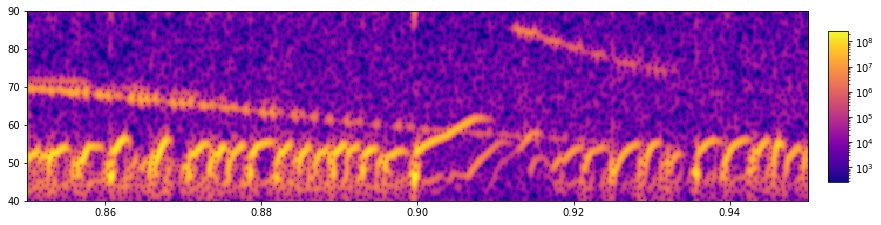

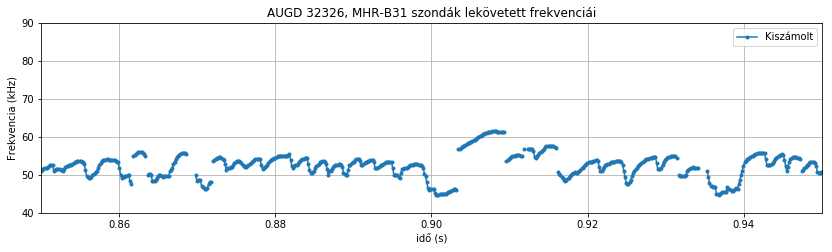

(667,)


In [492]:
#%%script false
#ridge_no = 1

best_shot=4 ##!!!! User-defined
print("Kiválasztott shot: ",str(sav1['channels'][best_shot])[2:4]+'R'+str(sav1['channels'][best_shot])[5:-1])

print(z_win_fft_cutted[best_shot].shape)
print(z_win_fft.shape)
ridge_d=10000#50# #windth of search if rige is lost, in Hz
ridge_d2=3000   #width of search if rige is followed, in Hz
ridge_start=50000#2#
ridge = np.zeros(int(samples/d_win+0.9))
ridge_h = np.zeros((loops,int(samples/d_win+0.9)))
maxi=z_win_fft_cutted[best_shot].max()/1000 # minimum treshold
print(np.log10(maxi))

for i in range(int(samples/d_win+0.9)):
    ridgeval=0  #max(z_spy_stft[i][:])
    if (i==0) or (ridge[i-1]==0):
        for j in range(int(ridge_d*(2*win_r+1)/(s_rate-0.9))):
            j2=j+int((ridge_start)*(2*win_r+1)/(s_rate-0.9))
            if ridgeval < z_win_fft_cutted[best_shot][j2][i]:
                ridgeval=z_win_fft_cutted[best_shot][j2][i]
                ridge[i]= j2
    else:
        for j in range(int(ridge_d2*(2*win_r+1)/(s_rate-0.9))):
            j2=int(j+ridge[i-1]-(ridge_d2/2)*(2*win_r+1)/(s_rate-0.9))
            if ridgeval < z_win_fft_cutted[best_shot][j2][i]:
                ridgeval=z_win_fft_cutted[best_shot][j2][i]
                ridge[i]= j2
                #print(j2, z_spy_stft[j2][i])
    if ridgeval<(maxi):
        ridgeval =0
        ridge [i]=0
    ridge_h[:,i]=z_win_fft_cutted[:,int(ridge[i]),i]
    #print(i, ridge [i])
    #print (i,"  ",ridge[i],"\t", ridgeval,"\t", z_spy_stft[i][int(ridge[i])])

ridge=ridge*(s_rate/(2*win_r+1))
#print(ridge)
print(np.log10(np.max(ridge_h)))


logax = np.linspace(int(np.log10(vmin)),int(np.log10(vmax)),int(np.log10(vmax))-int(np.log10(vmin))+1)
logax = 10**logax
plt.figure(figsize=(14,3.5))
plt.imshow(z_win_fft_cutted[best_shot],cmap='plasma',  aspect='auto', extent=[min_t,max_t,frangemax/1000,0], norm=colornorm)
plt.ylim(40,90)
cbar=plt.colorbar(img,cax=plt.axes([0.92, 0.2, 0.02, 0.6]),ticks=None)#/np.sqrt(loops)
plt.show()

ridge_t=np.linspace(min_t,max_t,np.size(ridge))
ridge[ ridge==0 ] = np.nan

plt.figure(figsize=(14,3.5))
#plt.title(shot+' szonda maximum frekvenciaértékei')
plt.plot(ridge_t,ridge/1000,'.-')
plt.grid(True)
plt.legend(('Kiszámolt', 'Eredeti'))
plt.xlim(min_t,max_t)
plt.title(shot[:-3]+' szondák lekövetett frekvenciái')
plt.ylim(40,90)
#plt.xlim(0.89,0.91)
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')
plt.savefig(save_shot+'_f_max.pdf')
plt.show()
#print(z_spy_stft.shape)
print(ridge.shape)

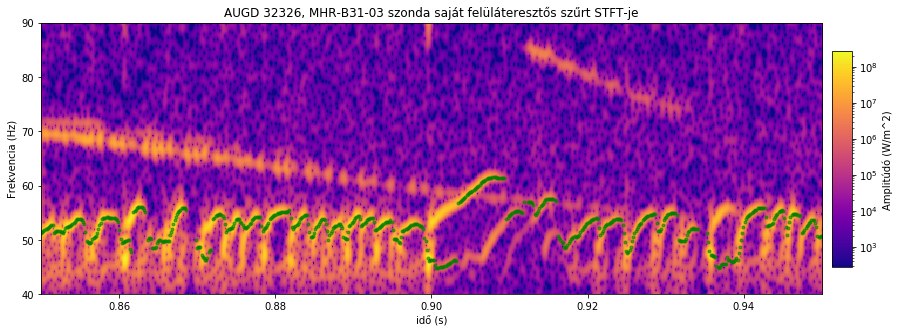

In [496]:
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(ridge_t,ridge/1000,'.',color='g',alpha=0.6)
img = plt.imshow(z_win_fft_cutted[best_shot],cmap='plasma',aspect='auto',extent=[min_t,max_t,frangemax/1000,0], norm=colornorm)#interpolation='gaussian',*30000000/4
plt.title(shot+' szonda saját felüláteresztős szűrt STFT-je')
plt.ylabel('Frekvencia (Hz)')
plt.xlabel('idő (s)')#('time (s)')
plt.ylim(40,90)#frangemax
#plt.xlim(1.9,2.4)
plt.subplots_adjust(right=0.90)
cbar=plt.colorbar(img,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label(amp_name)
#cbar.set_ticks(logax)
plt.savefig(save_shot+'_'+str(100*min_t)[:2]+'-'+str(100*max_t)[:2]+'_stft_max.pdf')#34924_40
plt.show()

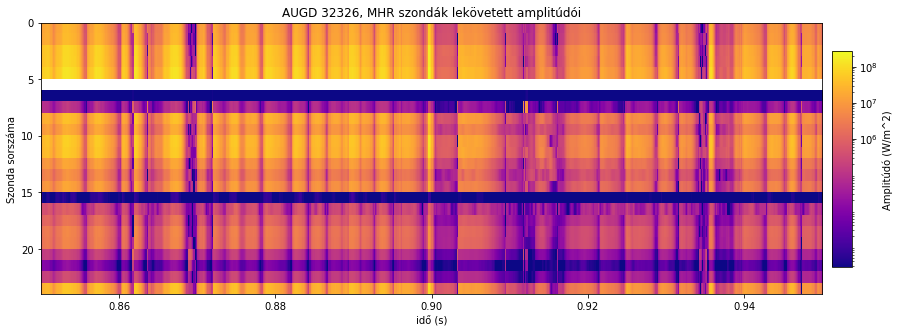

In [494]:
fig, ax = plt.subplots(figsize=(14,5))
colornorm=colors.LogNorm(vmin=stft_max/10**6, vmax=stft_max)
img = plt.imshow(ridge_h,cmap='plasma',  aspect='auto', extent=[min_t,max_t,loops,0], norm=colornorm)#interpolation='gaussian',*30000000/4
plt.title(shot[:-7]+' szondák lekövetett amplitúdói')#shot[-5:]
plt.ylabel('Szonda sorszáma')
plt.xlabel('idő (s)')#('time (s)')
#plt.ylim(40,90)#frangemax
#plt.xlim(1.9,2.4)
plt.subplots_adjust(right=0.90)
cbar=plt.colorbar(img,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label(amp_name)
cbar.set_ticks(logax)
plt.savefig(save_shot+'_'+str(min_t*100)[:2]+'-'+str(max_t*100)[:2]+'_MHDamp.pdf')#34924_40
plt.show()

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]
0 667 667
1.1116666666666666


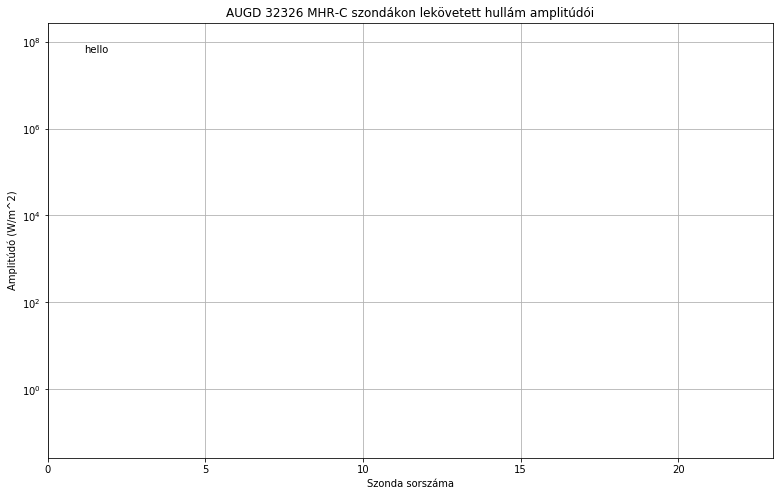

In [487]:
loops_x=np.zeros(loops)
for i in range(loops):
    loops_x[i]=i#str(sav1['channels'][i])[8:-1]#
print(loops_x)

t_start = 0.85
t_end = 0.95
frames = 600

i_start = int((t_start-min_t)/t*np.size(ridge_t))
i_end = int((t_end-min_t)/t*np.size(ridge_t))
print(i_start,i_end,np.size(ridge_t))
timestep= (i_end-i_start)/(frames)
print(timestep)

fig = plt.figure(figsize=(13,8))
ax = plt.axes(xlim=(np.max(loops_x), np.min(loops_x)), ylim=(stft_max/10**0, stft_max/10**10))
time_text = ax.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
line, = plt.plot([], [],'o-',markersize=5)#, lw=3
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.yscale("log")
plt.grid(True)
plt.ylabel(amp_name)#(W/m^2)
plt.xlabel('Szonda sorszáma')#Látókúp sorszáma (SXR-F-...)
plt.title(str(os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10]+' '+sxr_name[:5]+" szondákon lekövetett hullám amplitúdói"))

def init():
    line.set_data([], [])
    time_text.set_text('hello')
    return line, time_text
def animate(i):
    line.set_data(loops_x,ridge_h[:,int(timestep*i)])
    time_text.set_text(str(ridge_t[int(timestep*i)])[:6]+" s \n"+str(ridge[int(timestep*i)])[:6]+" Hz")
    return line, time_text

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=40, repeat_delay=1000, repeat=True, blit=True)

In [ ]:
%%script false
from matplotlib.animation import FFMpegWriter
writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1000)
anim.save((str(os.path.basename(filename)[:4]+'_'+os.path.basename(filename)[5:10]+'_'+sxr_name+"_MHA_log.mp4")), writer=writer)

In [ ]:
%%script false
HTML(anim.to_html5_video())

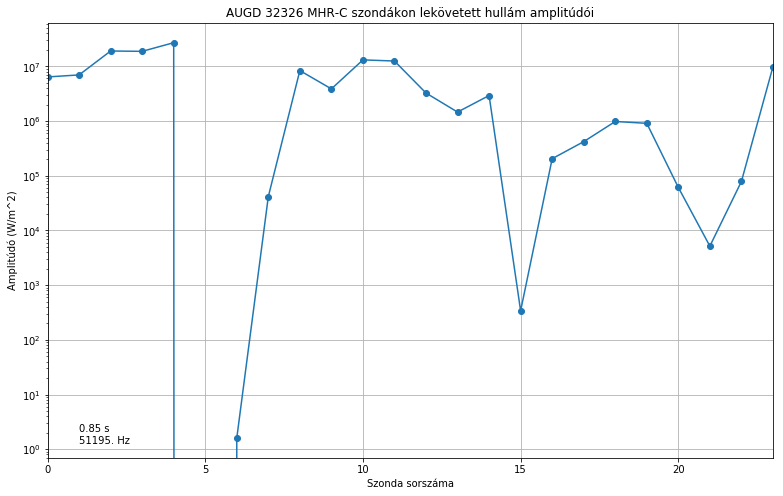

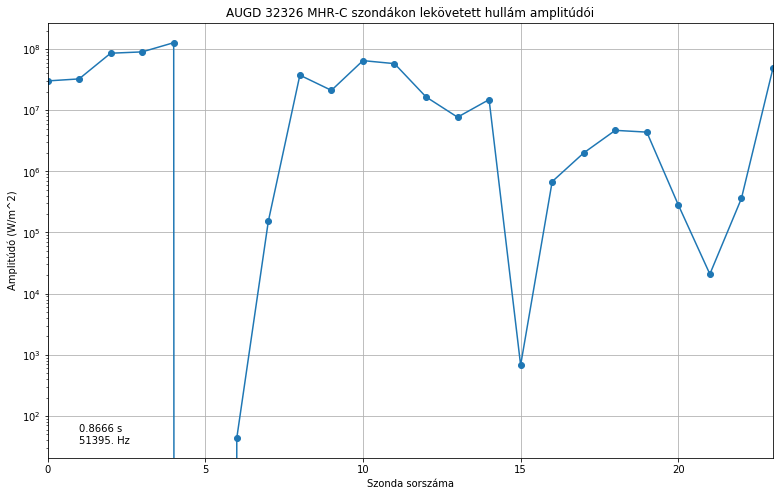

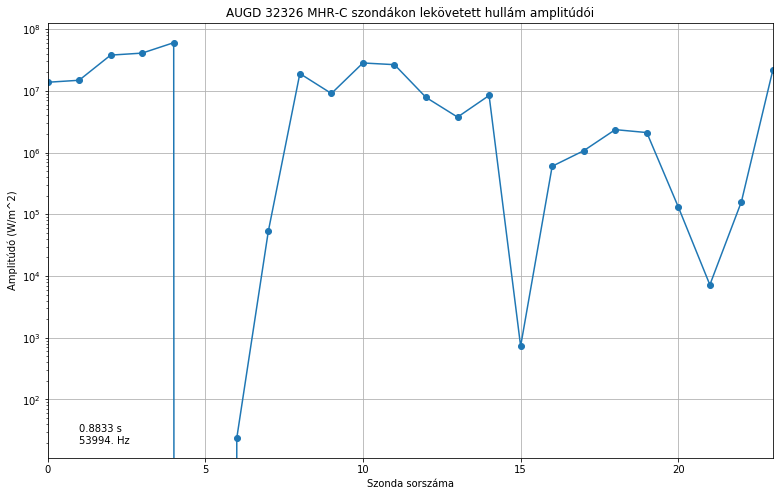

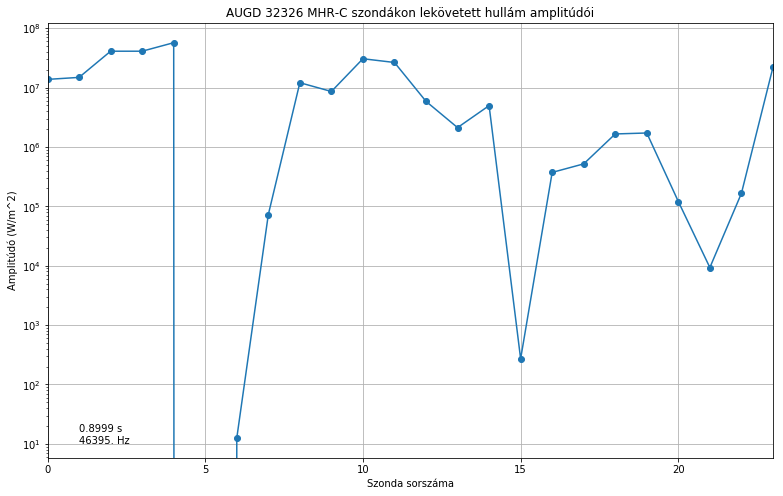

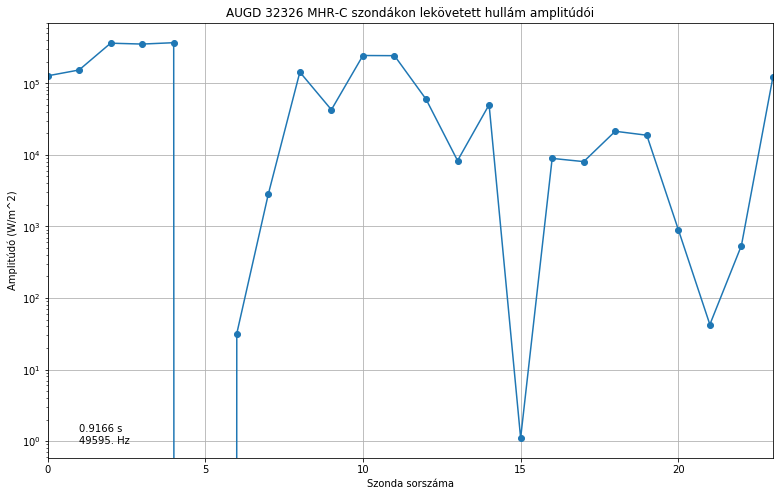

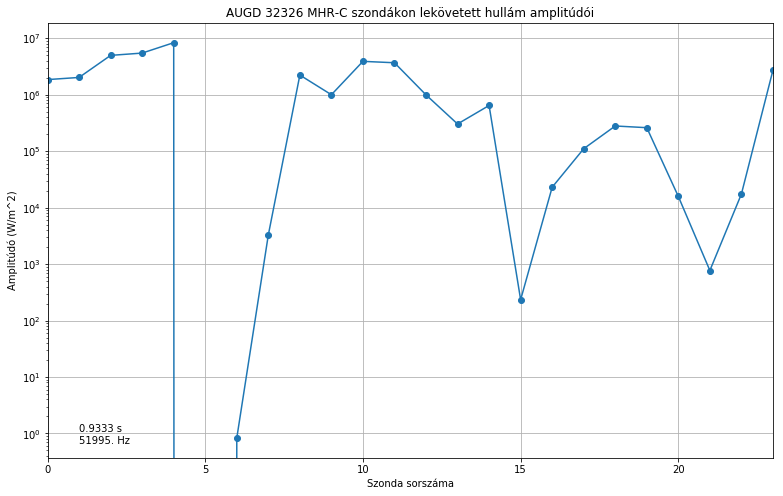

In [499]:
k=6
for i in range(k):
    plt.figure(figsize=(13,8))
    plt.plot(loops_x,ridge_h[:,int(timestep*frames*i/k)],'o-')
    tim_text = plt.text(-0.06, 0.1,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
    tim_text.set_text(str(ridge_t[int(timestep*frames*i/k)])[:6]+" s \n"+str(ridge[int(timestep*frames*i/k)])[:6]+" Hz")
    plt.yscale("log")
    plt.grid(True)
    plt.ylabel(amp_name)
    plt.xlim((np.min(loops_x),np.max(loops_x)))
    plt.xlabel('Szonda sorszáma')
    plt.title(str(os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10]+' '+sxr_name[:5]+" szondákon lekövetett hullám amplitúdói"))
    plt.savefig(save_shot+'_'+str(i)+'_amps.pdf')
    plt.show()

In [ ]:
##linear plot
ridge_h[ ridge_h==0 ] = np.nan
print(maxi**(1/2))
plt.figure(figsize=(10,3.5))
plt.title('Az amplitúdó a maximum frekvenciaértékeknél, '+shot)#, AUGD 34924 J051-es szonda
plt.plot(ridge_x,ridge_h[best_shot],ridge_x,ridge_h[0],'-',markersize=1)#,x,3*abs(np.sin(2*np.pi*x))+2,
plt.grid(True)
plt.xlim(min_t,max_t)
#plt.xlim(0.89,0.91)
#plt.ylim(maxi**(1/2)/2,max(ridge_h)*1.05)
plt.ylabel('Amplitúdó (W/m^2)')
plt.xlabel('idő (s)')
plt.yscale("log")
plt.savefig(shot+'_amp.pdf')
plt.show()
print(ridge.shape)

## Tasks
<br> 
<br> Import and evaluate chirps
<br> Reconstruct wave frequencies and amplitudes
<br> Get the radial ?function of several wave types